# Multivariate single gaussian for anomaly detectoin

먼저 필요한 라이브러리를 불러옵니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13
import warnings
warnings.filterwarnings("ignore")

필요한 함수들을 정의합니다.

In [2]:
# 데이터셋을 불러오는 함수
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

# 데이터 셋의 피쳐를 정규화하는 함수
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

# 가우시안 분포 추정 함수
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
# 다변량 가우시안에서 pdf를 리턴하는 함수
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

# Validiation dataset을 통해 가장 좋은 epsilon(임계치) 탐색
def selectThresholdByCV(probs,gt):      
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon) 
        f = f1_score(gt, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

먼저 필요한 파일을 불러옵니다.

In [3]:
tr_data = read_dataset('./data/tr_server_data.csv') 
cv_data = read_dataset('./data/cv_server_data.csv') 
gt_data = read_dataset('./data/gt_server_data.csv')

In [4]:
n_training_samples = tr_data.shape[0] # 트레이닝 데이터의 갯수
n_dim = tr_data.shape[1] # 트레이닝 데이터의 피처 갯수

print('Number of datapoints in training set: %d' % n_training_samples)
print('Number of dimensions/features: %d' % n_dim)

Number of datapoints in training set: 307
Number of dimensions/features: 2


첫 4개의 데이터를 확인한다.

In [5]:
print(tr_data[1:5,:])

[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


데이터를 시각화한다.

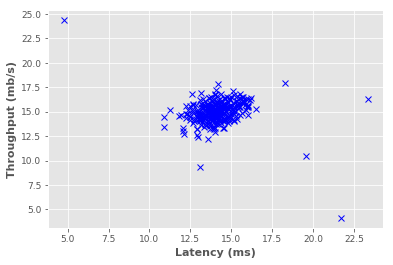

In [6]:
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.show()

가우시안 분포 추정을 한다. mu와 sigma를 구한다.

In [7]:
mu, sigma = estimateGaussian(tr_data)

In [8]:
mu

array([14.11225277, 14.99767459])

In [9]:
sigma

array([[ 1.83866684, -0.22783493],
       [-0.22783493,  1.71530264]])

트레이닝 데이터의 PDF로 부터 확률 값들을 구한다.

In [10]:
p = multivariateGaussian(tr_data,mu,sigma)

Validation dataset을 통해 최적의 epsilon 값을 구한다.

In [11]:
#selecting optimal value of epsilon using validation dataset
p_cv = multivariateGaussian(cv_data,mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,gt_data)
#print(fscore, ep)

epsilon 보다 작은 것들을 아웃라이어로 지정한다.

In [12]:
#selecting outlier datapoints 
outliers = np.asarray(np.where(p < ep))

결과를 시각화한다.

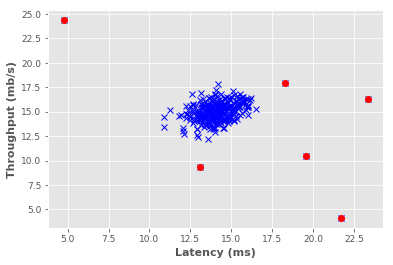

In [13]:
plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.plot(tr_data[outliers,0],tr_data[outliers,1],'ro')
plt.show()